# Prediction of protein subcellular localisation - Jorge Martínez (M2BI)

## Load modules

In [1]:
# Standard libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Data processing and analysis
from sklearn.metrics import confusion_matrix
from sklearn.utils import class_weight
from scipy.ndimage import gaussian_filter1d

# Deep learning framework
import tensorflow as tf
from tensorflow import keras

# Keras modules
from keras import layers, models, utils, callbacks, optimizers
from keras.models import Sequential, Model
from keras.layers import (
    Dense, Dropout, Add, Permute, Activation, Input,
    Conv1D, MaxPooling1D, BatchNormalization, AveragePooling1D, Concatenate,
    Flatten
)
from keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping

from scikeras import wrappers
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection     import KFold
from sklearn.model_selection     import cross_val_score

# Visualization
import seaborn as sns

## Load data and take a first look

In [2]:
# Load the data
train = np.load("../data/reduced_train.npz")
test = np.load("../data/reduced_val.npz")

# Create the x and y data for the train and test sets
x_train = train['X_train']
y_train = train['y_train']

x_test = test['X_val']
y_test = test['y_val']

# Basic Information
print("Shape of x_train:", x_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of x_test:", x_test.shape)
print("Shape of y_test:", y_test.shape)

# Data Types
print("\nData types:")
print("x_train dtype:", x_train.dtype)
print("y_train dtype:", y_train.dtype)

# Missing Values
print("\nMissing values in x_train:", np.isnan(x_train).sum())
print("Missing values in y_train:", np.isnan(y_train).sum())

Shape of x_train: (2423, 400, 20)
Shape of y_train: (2423,)
Shape of x_test: (635, 400, 20)
Shape of y_test: (635,)

Data types:
x_train dtype: float32
y_train dtype: int32

Missing values in x_train: 0
Missing values in y_train: 0


In [3]:
# Sample Data
print("\nFirst 5 rows of x_train:")
print(x_train[:5])
print("\nFirst 5 rows of y_train:")
print(y_train[:5])


First 5 rows of x_train:
[[[0.   0.   0.   ... 0.   0.   0.  ]
  [1.   0.   0.   ... 0.   0.   0.  ]
  [0.   0.   0.   ... 0.   0.   0.  ]
  ...
  [0.   0.   0.   ... 0.   0.   0.  ]
  [0.   0.   0.   ... 0.   0.   0.  ]
  [0.   0.   0.   ... 0.   0.   0.  ]]

 [[0.   0.   0.   ... 0.   0.   0.  ]
  [0.   0.48 0.   ... 0.   0.   0.  ]
  [0.   0.   0.   ... 0.   0.   0.  ]
  ...
  [0.   0.   0.   ... 0.   0.   0.  ]
  [0.   0.   0.   ... 0.   0.   0.  ]
  [0.   0.   0.   ... 0.   0.   0.  ]]

 [[0.   0.   0.   ... 0.   0.   0.  ]
  [1.   0.   0.   ... 0.   0.   0.  ]
  [0.   0.   0.   ... 0.   0.   0.  ]
  ...
  [0.   0.   0.   ... 0.   0.   0.  ]
  [0.   0.   0.   ... 0.   0.   0.  ]
  [0.   0.   0.   ... 0.   0.   0.  ]]

 [[0.   0.   0.   ... 0.   0.   0.  ]
  [1.   0.   0.   ... 0.   0.   0.  ]
  [1.   0.   0.   ... 0.   0.   0.  ]
  ...
  [0.   0.   0.   ... 0.   0.   0.  ]
  [0.   0.   0.   ... 0.   0.   0.  ]
  [0.   0.   0.   ... 0.   0.   0.  ]]

 [[0.   0.   0.   ... 0.   0. 


Class distribution in y_train:
Class 0: 338 samples
Class 1: 567 samples
Class 2: 535 samples
Class 3: 233 samples
Class 4: 285 samples
Class 5: 63 samples
Class 6: 224 samples
Class 7: 59 samples
Class 8: 60 samples
Class 9: 59 samples


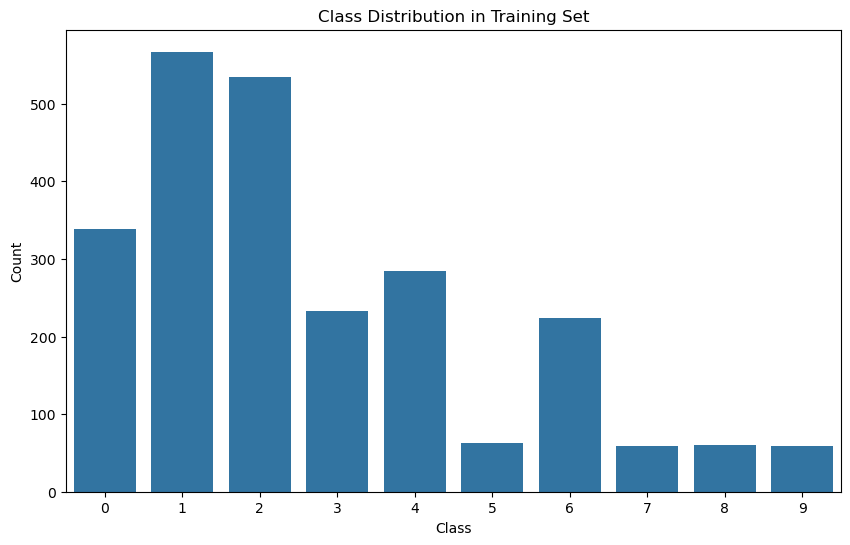

In [4]:
# Class Distribution
unique, counts = np.unique(y_train, return_counts=True)
print("\nClass distribution in y_train:")
for u, c in zip(unique, counts):
    print(f"Class {u}: {c} samples")
    
# Plot Class Distribution
plt.figure(figsize=(10, 6))
sns.countplot(x=y_train)
plt.title("Class Distribution in Training Set")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

In [5]:
# One hot encoding
num_classes = len(np.unique(y_train))

y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

## Base

### DNN

In [6]:
def dnn_model():
    model = Sequential([
        Input(shape=(400,20)),
        Flatten(),
        Dense(32, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation="softmax")
    ])
    
    model.compile(optimizer=optimizers.Adam(learning_rate=0.0005),
                  loss="categorical_crossentropy",
                  metrics=["accuracy"])
    
    return model

# Create the model 
model_dnn = dnn_model()
model_dnn.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 8000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │       256,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 256,362 (1001.41 KB)

 Trainable params: 256,362 (1001.41 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
callback = callbacks.EarlyStopping(monitor = 'val_accuracy',
                                patience = 5,
                                mode = 'max',
                                restore_best_weights=True)

history_dnn = model_dnn.fit(x_train, y_train, 
                    epochs=80, 
                    batch_size=128, 
                    validation_split = 0.2,
                    callbacks = [callback])

Epoch 1/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.2028 - loss: 2.2368 - val_accuracy: 0.3134 - val_loss: 2.0516
Epoch 2/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3135 - loss: 2.0147 - val_accuracy: 0.3320 - val_loss: 1.9194
Epoch 3/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3746 - loss: 1.8268 - val_accuracy: 0.4186 - val_loss: 1.8231
Epoch 4/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4153 - loss: 1.7241 - val_accuracy: 0.4515 - val_loss: 1.7453
Epoch 5/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4978 - loss: 1.5777 - val_accuracy: 0.4928 - val_loss: 1.6690
Epoch 6/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5314 - loss: 1.4769 - val_accuracy: 0.5278 - val_loss: 1.6008
Epoch 7/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5776 - loss: 1.3582 - val_accuracy: 0.5505 - val_loss: 1.5413
Epoch 8/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6140 - loss: 1.2726 - val_accuracy: 0.5835 - val_loss

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 637us/step - accuracy: 0.7031 - loss: 0.9250
Test accuracy: 0.7055


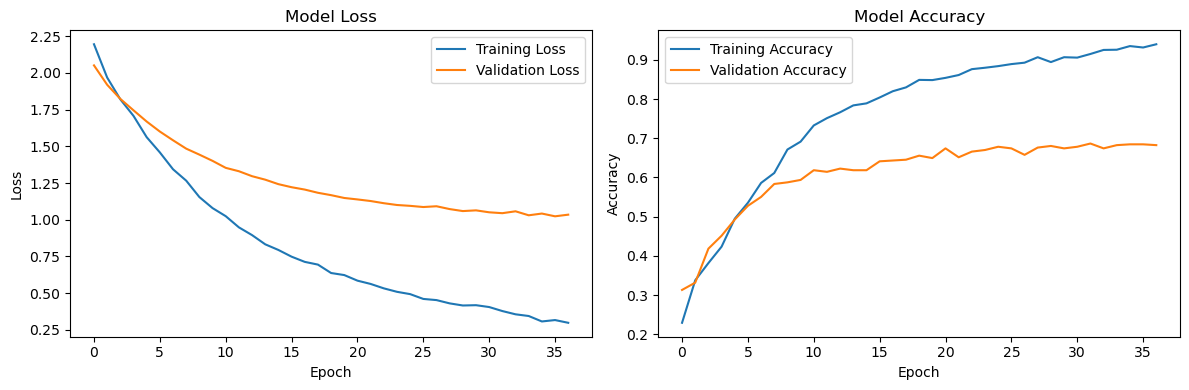

In [8]:
# Evaluate the model
test_loss_dnn, test_accuracy_dnn = model_dnn.evaluate(x_test, y_test)
print(f"Test accuracy: {test_accuracy_dnn:.4f}")


plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_dnn.history['loss'], label='Training Loss')
plt.plot(history_dnn.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_dnn.history['accuracy'], label='Training Accuracy')
plt.plot(history_dnn.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()


plt.tight_layout()
plt.show()

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


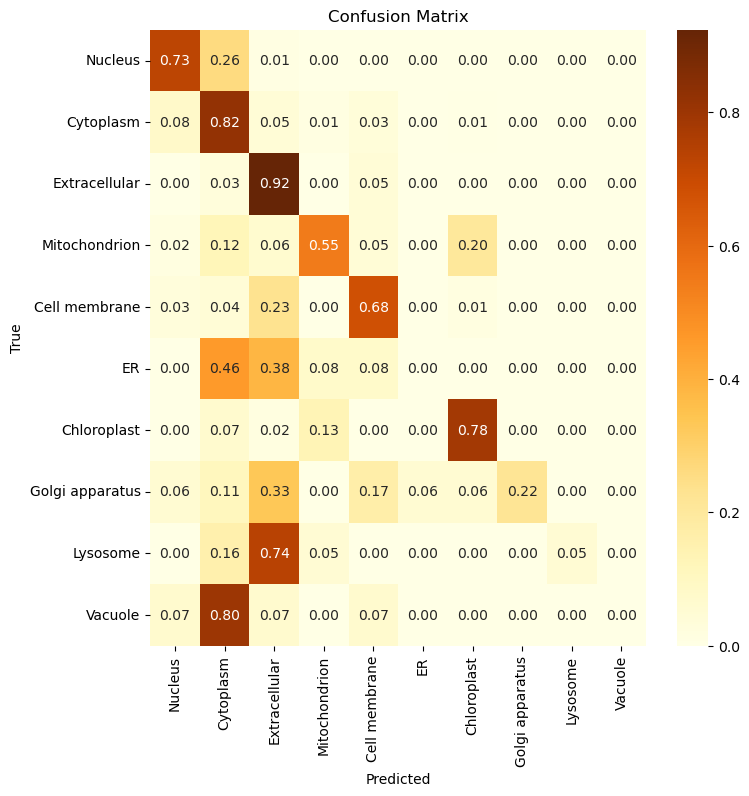

In [9]:
# Make predictions
y_pred = model_dnn.predict(x_test)


# Convert one-hot encoded labels back to class indices
y_test_classes = np.argmax(y_test, axis=1)
y_pred_classes = np.argmax(y_pred, axis=1)

classes = ['Nucleus','Cytoplasm','Extracellular','Mitochondrion','Cell membrane','ER',
           'Chloroplast','Golgi apparatus','Lysosome','Vacuole']

# Create confusion matrix
cm = confusion_matrix(y_test_classes, y_pred_classes, normalize='true')

# Plot confusion matrix
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='.2f', xticklabels=classes, yticklabels=classes, cmap='YlOrBr')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [10]:
# Save the model
model_dnn.save('../res/model_dnn.h5')

### CNN

In [11]:
def cnn_model():
    model = Sequential([
        Input(shape=(400,20)),
        Conv1D(32,
               kernel_size=3,
               padding='same',
               activation='relu'),
        AveragePooling1D(pool_size=2),
        Dropout(0.5),
        BatchNormalization(),
        
        Conv1D(64,
               kernel_size=5,
               padding='same',
               activation='relu'),
        AveragePooling1D(pool_size=2),
        Dropout(0.5),
        BatchNormalization(),
        Flatten(),
        Dense(num_classes, activation="softmax")
    ])
    
    model.compile(optimizer=optimizers.Adam(learning_rate=0.0005),
                  loss="categorical_crossentropy", metrics=["accuracy"])
    
    return model

# Create the model
model_cnn = cnn_model()
model_cnn.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 400, 32)        │         1,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling1d               │ (None, 200, 32)        │             0 │
│ (AveragePooling1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 200, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 200, 32)        │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 200, 64)        │        10,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling1d_1             │ (None, 100, 64)        │             0 │
│ (AveragePooling1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 100, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 100, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 6400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │        64,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 76,650 (299.41 KB)

 Trainable params: 76,458 (298.66 KB)

 Non-trainable params: 192 (768.00 B)

In [12]:
history_cnn = model_cnn.fit(
    x_train, y_train,
    batch_size = 128,
    epochs = 80,
    validation_split=0.2)

Epoch 1/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.1661 - loss: 2.7675 - val_accuracy: 0.2680 - val_loss: 2.2265
Epoch 2/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.2984 - loss: 2.1741 - val_accuracy: 0.2247 - val_loss: 2.2308
Epoch 3/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.3887 - loss: 1.8450 - val_accuracy: 0.2330 - val_loss: 2.2336
Epoch 4/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.4593 - loss: 1.6238 - val_accuracy: 0.2474 - val_loss: 2.2357
Epoch 5/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5181 - loss: 1.4291 - val_accuracy: 0.2887 - val_loss: 2.2819
Epoch 6/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.5846 - loss: 1.2303 - val_accuracy: 0.2495 - val_loss: 2.2660
Epoch 7/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.6280 - loss: 1.1071 - val_accuracy: 0.2474 - val_loss: 2.3051
Epoch 8/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.6870 - loss: 0.9397 - val_accuracy: 0.2784 - v

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8372 - loss: 0.7352
Test accuracy: 0.8394


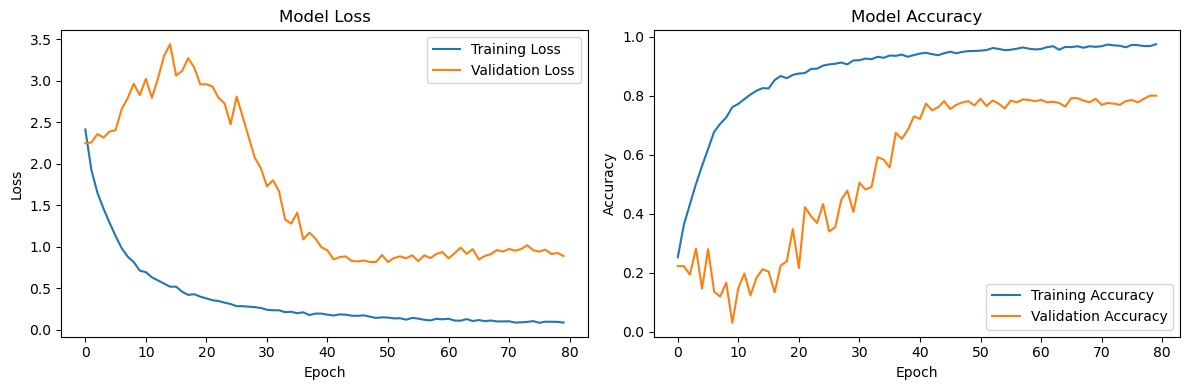

In [13]:
# Evaluate the model
test_loss_cnn, test_accuracy_cnn = model_cnn.evaluate(x_test, y_test)
print(f"Test accuracy: {test_accuracy_cnn:.4f}")


plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_cnn.history['loss'], label='Training Loss')
plt.plot(history_cnn.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_cnn.history['accuracy'], label='Training Accuracy')
plt.plot(history_cnn.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()


plt.tight_layout()
plt.show()

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


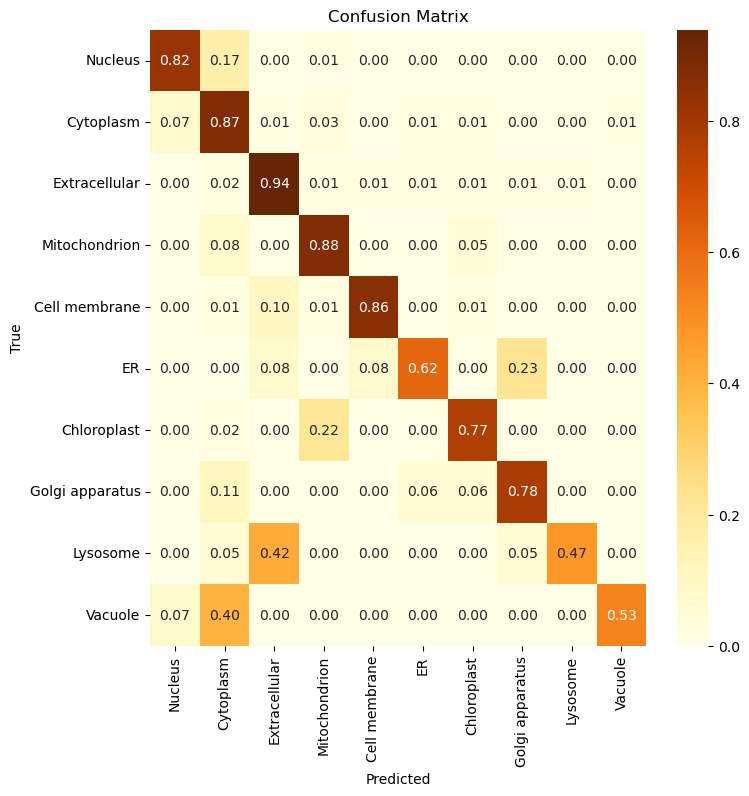

In [14]:
# Make predictions
y_pred = model_cnn.predict(x_test)

# Convert one-hot encoded labels back to class indices
y_test_classes = np.argmax(y_test, axis=1)
y_pred_classes = np.argmax(y_pred, axis=1)

# Create confusion matrix
cm = confusion_matrix(y_test_classes, y_pred_classes, normalize='true')

# Plot confusion matrix
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='.2f', xticklabels=classes, yticklabels=classes, cmap='YlOrBr')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [15]:
# Save the model
model_cnn.save('../res/model_cnn.h5')

### CNN - functional API

In [16]:
def cnn_api_model():
    inputs = Input(shape=(400,20))
    
    # Make two parallel convolutional layers with different kernel sizes
    conv_1 = Conv1D(32,
                    kernel_size=3,
                    padding="same",
                    activation="relu")(inputs)
    conv_2 = Conv1D(32,
                    kernel_size=5,
                    padding="same",
                    activation="relu")(inputs)
    
    convs = Concatenate(axis=1)([conv_1, conv_2])
    
    # Second simple convolutional layer
    conv_3 = Conv1D(64,
                    kernel_size=3,
                    padding="same",
                    activation="relu")(convs)
    
    # Reduce dimensions
    max_pool = MaxPooling1D(pool_size = 5)(conv_3)
    
    # Flatten to apply a dense layer
    flat = Flatten()(max_pool)
    dense = Dense(32, activation="relu")(flat)
    drop = Dropout(0.5)(dense)
    
    # Output layer
    outputs = Dense(num_classes, activation="softmax")(drop)
    
    
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=optimizers.Adam(learning_rate=0.0005),
                  loss="categorical_crossentropy", metrics=["accuracy"])
    
    return model

# Create the model
model_cnn_api = cnn_api_model()
model_cnn_api.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 400, 20)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 400, 32)   │      1,952 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 400, 32)   │      3,232 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 800, 32)   │          0 │ conv1d_2[0][0],   │
│ (Concatenate)       │                   │            │ conv1d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 800, 64)   │      6,208 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 160, 64)   │          0 │ conv1d_4[0][0]    │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 10240)     │          0 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 32)        │    327,712 │ flatten_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 32)        │          0 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 10)        │        330 │ dropout_3[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 339,434 (1.29 MB)

 Trainable params: 339,434 (1.29 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
history_cnn_api = model_cnn_api.fit(
    x_train, y_train,
    batch_size = 128,
    epochs = 80,
    validation_split=0.2)

Epoch 1/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.1870 - loss: 2.1881 - val_accuracy: 0.3072 - val_loss: 2.0317
Epoch 2/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.2803 - loss: 2.0313 - val_accuracy: 0.3732 - val_loss: 1.9961
Epoch 3/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.2924 - loss: 1.9588 - val_accuracy: 0.3918 - val_loss: 1.8912
Epoch 4/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.3396 - loss: 1.8643 - val_accuracy: 0.4536 - val_loss: 1.8824
Epoch 5/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - accuracy: 0.3708 - loss: 1.8166 - val_accuracy: 0.4021 - val_loss: 1.7976
Epoch 6/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.3867 - loss: 1.7596 - val_accuracy: 0.4763 - val_loss: 1.7444
Epoch 7/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.4273 - loss: 1.6685 - val_accuracy: 0.5361 - val_loss: 1.6229
Epoch 8/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.4693 - loss: 1.5882 - val_accuracy: 0.5010 - v

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7576 - loss: 0.8052
Test accuracy: 0.7622


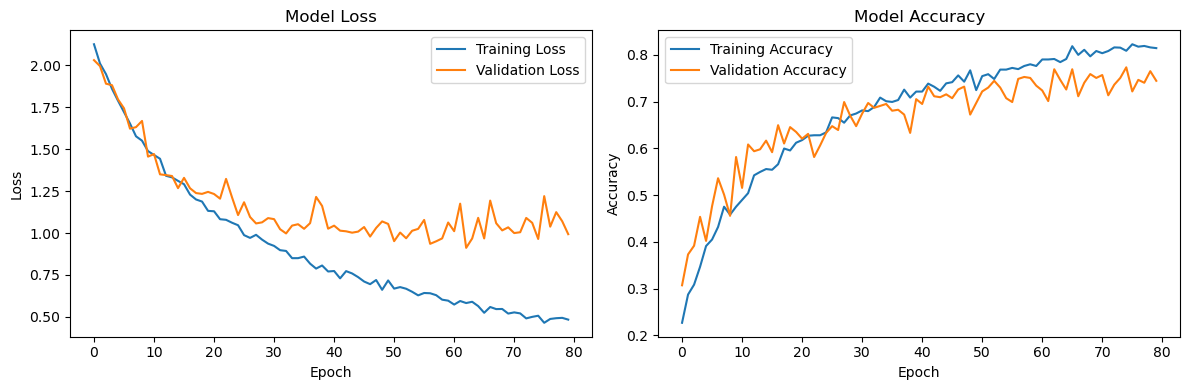

In [18]:
# Evaluate the model
test_loss_cnn_api, test_accuracy_cnn_api = model_cnn_api.evaluate(x_test, y_test)
print(f"Test accuracy: {test_accuracy_cnn_api:.4f}")


plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_cnn_api.history['loss'], label='Training Loss')
plt.plot(history_cnn_api.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_cnn_api.history['accuracy'], label='Training Accuracy')
plt.plot(history_cnn_api.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()


plt.tight_layout()
plt.show()

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


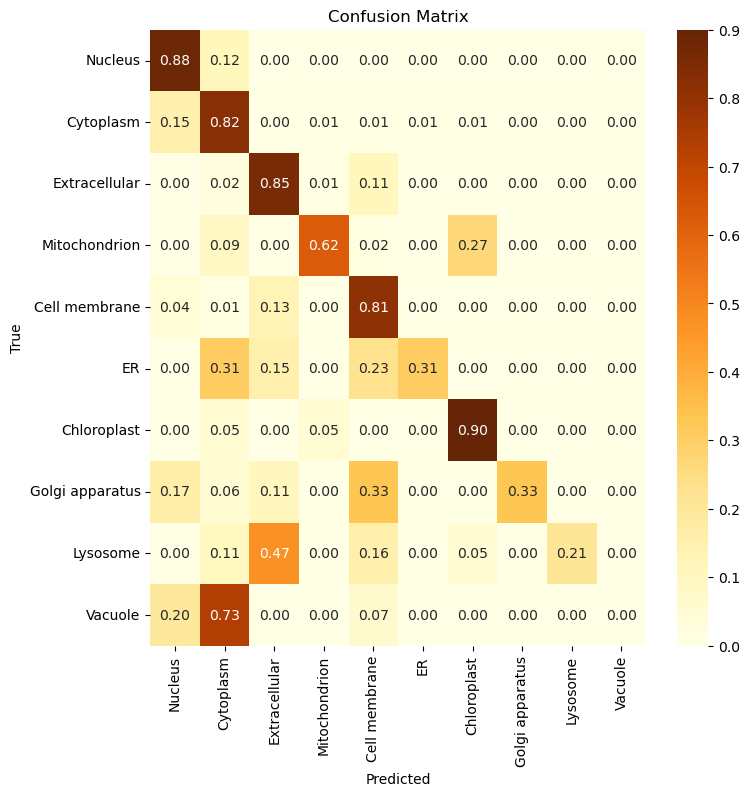

In [19]:
# Make predictions
y_pred = model_cnn_api.predict(x_test)

# Convert one-hot encoded labels back to class indices
y_test_classes = np.argmax(y_test, axis=1)
y_pred_classes = np.argmax(y_pred, axis=1)

# Create confusion matrix
cm = confusion_matrix(y_test_classes, y_pred_classes, normalize='true')

# Plot confusion matrix
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='.2f', xticklabels=classes, yticklabels=classes, cmap='YlOrBr')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [20]:
# Save the model
model_cnn_api.save('../res/model_cnn_api.h5')

### ResNet

In [21]:
# Define the residual block achitecture
def residual_block(x, filters, kernel_size=3, stride=1):
    shortcut = x
    
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv1D(filters, kernel_size = 1)(x)
    
    # Second convolution layer
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv1D(filters, kernel_size = kernel_size, 
               padding="same",
               strides = stride)(x)

    output = Add()([shortcut, x])
    return output

In [22]:
# Build the ResNet model
def resnet_model(input_shape=(400, 20), num_blocks=2):
    inputs = Input(shape=input_shape)
    
    residual_i = inputs
    
    for _ in range(num_blocks):
        residual_i = residual_block(residual_i, 20)
        
    gavg_1 = AveragePooling1D(2, strides=1)(residual_i)
    
    flat_1 = Flatten()(gavg_1)
    
    output = Dense(num_classes, activation="softmax")(flat_1)
    
    model = Model(inputs=inputs, outputs=output)
    
    model.compile(optimizer=optimizers.Adam(learning_rate=0.0005),
                  loss="categorical_crossentropy", metrics=["accuracy"])
                                                        
    return model

# Create the model
model_resnet = resnet_model()
model_resnet.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 400, 20)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 400, 20)   │         80 │ input_layer_3[0]… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 400, 20)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, 400, 20)   │        420 │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 400, 20)   │         80 │ conv1d_5[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 400, 20)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_6 (Conv1D)   │ (None, 400, 20)   │      1,220 │ activation_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 400, 20)   │          0 │ input_layer_3[0]… │
│                     │                   │            │ conv1d_6[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 400, 20)   │         80 │ add[0][0]         │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 400, 20)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_7 (Conv1D)   │ (None, 400, 20)   │        420 │ activation_2[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 400, 20)   │         80 │ conv1d_7[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 400, 20)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_8 (Conv1D)   │ (None, 400, 20)   │      1,220 │ activation_3[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 400, 20)   │          0 │ add[0][0],        │
│                     │                   │            │ conv1d_8[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling1d_2 │ (None, 399, 20)   │          0 │ add_1[0][0]       │
│ (AveragePooling1D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_3 (Flatten) │ (None, 7980)      │          0 │ average_pooling1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 10)        │     79,810 │ flatten_3[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 83,410 (325.82 KB)

 Trainable params: 83,250 (325.20 KB)

 Non-trainable params: 160 (640.00 B)

In [23]:
history_resnet = model_resnet.fit(
    x_train, y_train,
    batch_size = 128,
    epochs = 80,
    validation_split=0.2)

Epoch 1/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.2454 - loss: 2.6444 - val_accuracy: 0.2392 - val_loss: 2.1387
Epoch 2/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.5582 - loss: 1.3057 - val_accuracy: 0.3979 - val_loss: 2.0939
Epoch 3/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.7246 - loss: 0.8692 - val_accuracy: 0.2784 - val_loss: 2.0217
Epoch 4/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step - accuracy: 0.8480 - loss: 0.6158 - val_accuracy: 0.2784 - val_loss: 1.9669
Epoch 5/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.9025 - loss: 0.4011 - val_accuracy: 0.2866 - val_loss: 1.9262
Epoch 6/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.9493 - loss: 0.2624 - val_accuracy: 0.2639 - val_loss: 2.0316
Epoch 7/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.9709 - loss: 0.1938 - val_accuracy: 0.3072 - val_loss: 1.9646
Epoch 8/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - accuracy: 0.9745 - loss: 0.1660 - val_accuracy: 0.2268 - v

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7455 - loss: 1.8985
Test accuracy: 0.7402


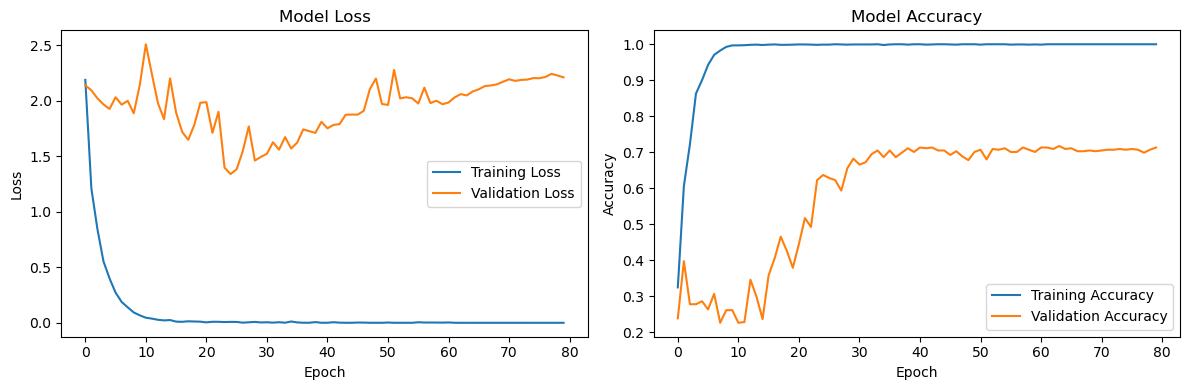

In [24]:
# Evaluate the model
test_loss_resnet, test_accuracy_resnet = model_resnet.evaluate(x_test, y_test)
print(f"Test accuracy: {test_accuracy_resnet:.4f}")


plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_resnet.history['loss'], label='Training Loss')
plt.plot(history_resnet.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_resnet.history['accuracy'], label='Training Accuracy')
plt.plot(history_resnet.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()


plt.tight_layout()
plt.show()

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


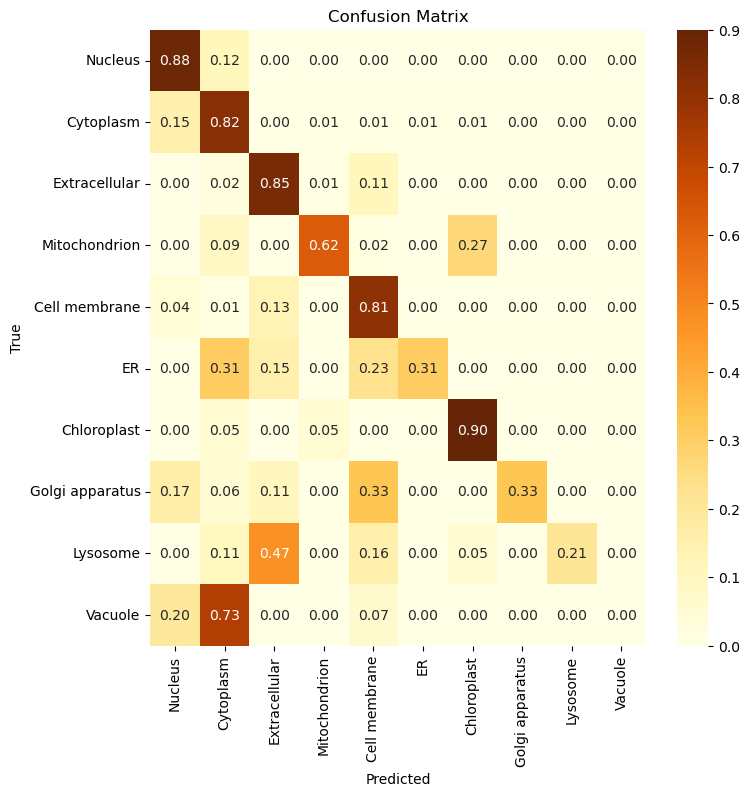

In [25]:
# Make predictions
y_pred = model_cnn_api.predict(x_test)

# Convert one-hot encoded labels back to class indices
y_test_classes = np.argmax(y_test, axis=1)
y_pred_classes = np.argmax(y_pred, axis=1)

# Create confusion matrix
cm = confusion_matrix(y_test_classes, y_pred_classes, normalize='true')

# Plot confusion matrix
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='.2f', xticklabels=classes, yticklabels=classes, cmap='YlOrBr')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [26]:
# Save the model
model_resnet.save('../res/model_resnet.h5')

## Include class weights

In [27]:
class_weights = class_weight.compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(np.argmax(y_train, axis=1)),
                                        y = np.argmax(y_train, axis=1)
                                    )
class_weights = dict(enumerate(class_weights))
print(f'Class Weights: {class_weights}\n')

Class Weights: {0: 0.7168639053254438, 1: 0.427336860670194, 2: 0.45289719626168223, 3: 1.0399141630901287, 4: 0.8501754385964913, 5: 3.846031746031746, 6: 1.0816964285714286, 7: 4.106779661016949, 8: 4.038333333333333, 9: 4.106779661016949}



### DNN

In [28]:
# Create the model 
model_dnn_cw = dnn_model()

history_dnn_cw = model_dnn_cw.fit(x_train, y_train, 
                    epochs=80, 
                    batch_size=128, 
                    validation_split = 0.2,
                    class_weight=class_weights)

Epoch 1/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.0819 - loss: 2.2627 - val_accuracy: 0.1732 - val_loss: 2.2548
Epoch 2/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2321 - loss: 2.0359 - val_accuracy: 0.3918 - val_loss: 2.1123
Epoch 3/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3228 - loss: 1.9135 - val_accuracy: 0.3093 - val_loss: 2.0560
Epoch 4/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3848 - loss: 1.8715 - val_accuracy: 0.3711 - val_loss: 1.9660
Epoch 5/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4326 - loss: 1.6499 - val_accuracy: 0.4577 - val_loss: 1.9202
Epoch 6/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5007 - loss: 1.5346 - val_accuracy: 0.5443 - val_loss: 1.7899
Epoch 7/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5449 - loss: 1.4316 - val_accuracy: 0.6021 - val_loss: 1.7338
Epoch 8/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5904 - loss: 1.2679 - val_accuracy: 0.5753 - val_loss:

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 601us/step - accuracy: 0.7253 - loss: 0.9249
Test accuracy: 0.7339


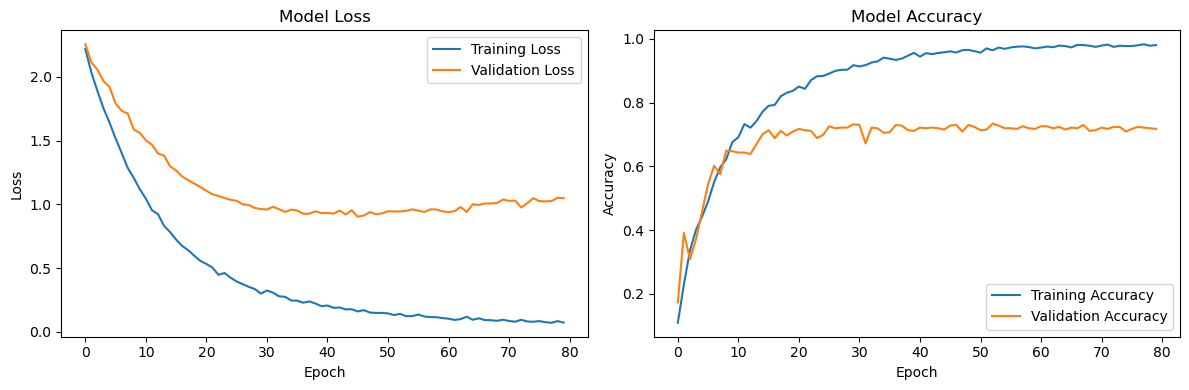

In [29]:
# Evaluate the model
test_loss_dnn_cw, test_accuracy_dnn_cw = model_dnn_cw.evaluate(x_test, y_test)
print(f"Test accuracy: {test_accuracy_dnn_cw:.4f}")


plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_dnn_cw.history['loss'], label='Training Loss')
plt.plot(history_dnn_cw.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_dnn_cw.history['accuracy'], label='Training Accuracy')
plt.plot(history_dnn_cw.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()


plt.tight_layout()
plt.show()

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


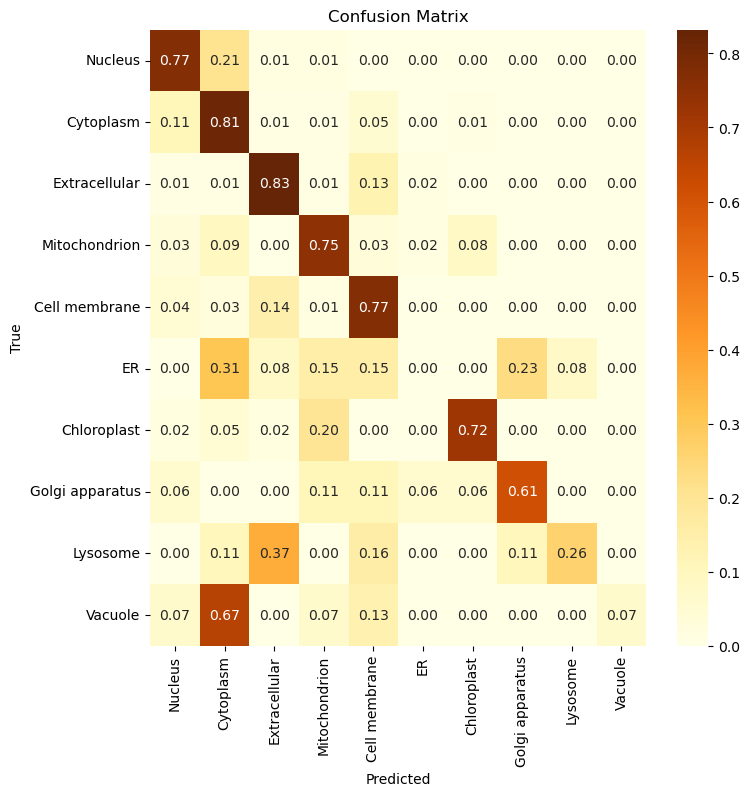

In [30]:
# Make predictions
y_pred = model_dnn_cw.predict(x_test)

# Convert one-hot encoded labels back to class indices
y_test_classes = np.argmax(y_test, axis=1)
y_pred_classes = np.argmax(y_pred, axis=1)

# Create confusion matrix
cm = confusion_matrix(y_test_classes, y_pred_classes, normalize='true')

# Plot confusion matrix
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='.2f', xticklabels=classes, yticklabels=classes, cmap='YlOrBr')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [31]:
# Save the model
model_dnn_cw.save('../res/model_dnn_cw.h5')

### CNN

In [32]:
model_cnn_cw = cnn_model()

history_cnn_cw = model_cnn_cw.fit(
    x_train, y_train,
    batch_size = 128,
    epochs = 80,
    validation_split=0.2,
    class_weight=class_weights)

Epoch 1/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.1522 - loss: 2.8267 - val_accuracy: 0.0577 - val_loss: 2.3220
Epoch 2/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.2967 - loss: 2.0255 - val_accuracy: 0.0227 - val_loss: 2.4603
Epoch 3/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.3439 - loss: 1.8812 - val_accuracy: 0.0227 - val_loss: 2.5842
Epoch 4/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.4115 - loss: 1.6484 - val_accuracy: 0.0227 - val_loss: 2.9764
Epoch 5/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.4620 - loss: 1.4555 - val_accuracy: 0.0227 - val_loss: 3.2848
Epoch 6/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.5082 - loss: 1.3221 - val_accuracy: 0.0227 - val_loss: 3.5695
Epoch 7/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.5979 - loss: 1.0982 - val_accuracy: 0.0227 - val_loss: 4.0201
Epoch 8/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.6151 - loss: 1.0256 - val_accuracy: 0.0227 - v

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3493 - loss: 4.6396
Test accuracy: 0.3543


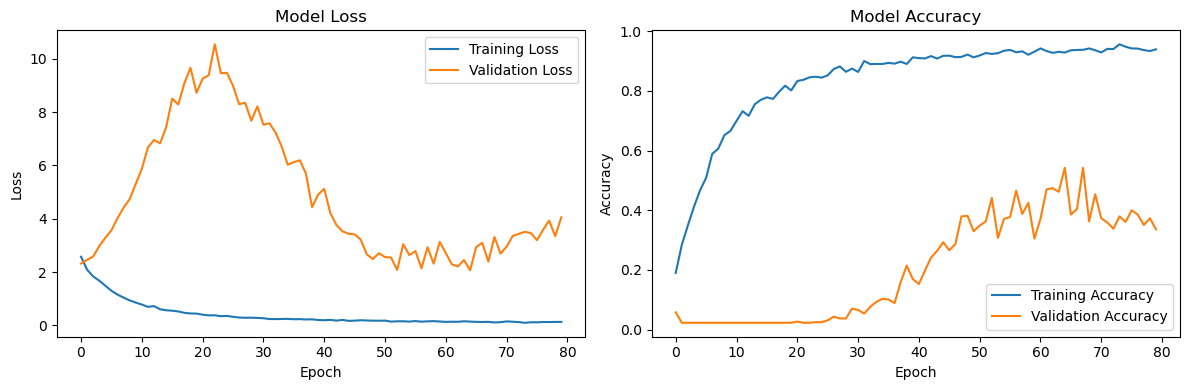

In [33]:
# Evaluate the model
test_loss_cnn_cw, test_accuracy_cnn_cw = model_cnn_cw.evaluate(x_test, y_test)
print(f"Test accuracy: {test_accuracy_cnn_cw:.4f}")


plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_cnn_cw.history['loss'], label='Training Loss')
plt.plot(history_cnn_cw.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_cnn_cw.history['accuracy'], label='Training Accuracy')
plt.plot(history_cnn_cw.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()


plt.tight_layout()
plt.show()

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


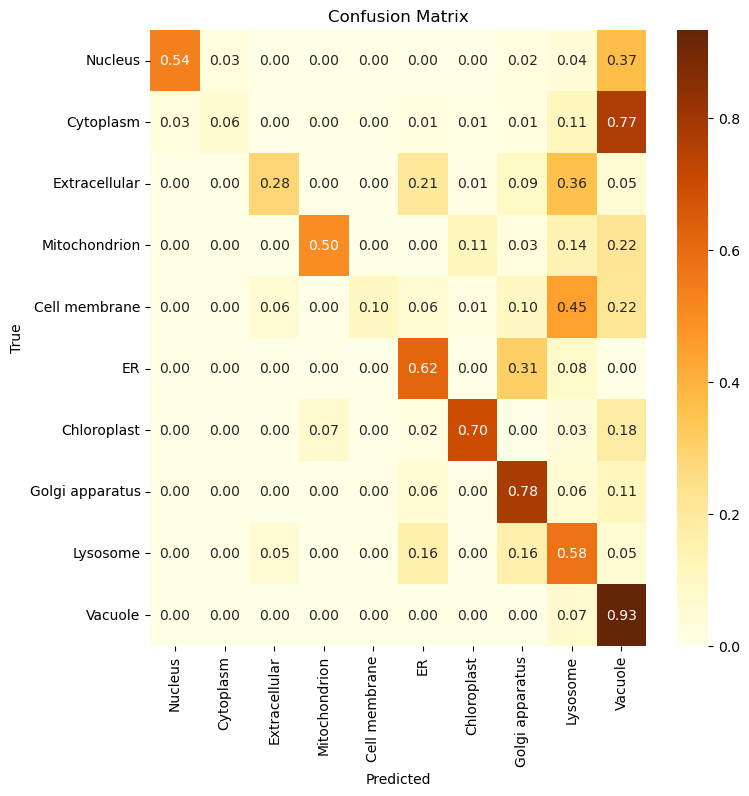

In [34]:
# Make predictions
y_pred = model_cnn_cw.predict(x_test)

# Convert one-hot encoded labels back to class indices
y_test_classes = np.argmax(y_test, axis=1)
y_pred_classes = np.argmax(y_pred, axis=1)

# Create confusion matrix
cm = confusion_matrix(y_test_classes, y_pred_classes, normalize='true')

# Plot confusion matrix
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='.2f', xticklabels=classes, yticklabels=classes, cmap='YlOrBr')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [35]:
# Save the model
model_cnn_cw.save('../res/model_cnn_cw.h5')

### CNN - functional API

In [36]:
model_cnn_api_cw = cnn_api_model()
history_cnn_api_cw = model_cnn_api_cw.fit(
    x_train, y_train,
    batch_size = 128,
    epochs = 80,
    validation_split=0.2,
    class_weight=class_weights)

Epoch 1/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - accuracy: 0.1196 - loss: 2.2813 - val_accuracy: 0.2392 - val_loss: 2.2648
Epoch 2/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.2110 - loss: 2.1481 - val_accuracy: 0.2392 - val_loss: 2.1990
Epoch 3/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.2228 - loss: 2.0513 - val_accuracy: 0.2990 - val_loss: 2.1279
Epoch 4/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.2545 - loss: 2.1767 - val_accuracy: 0.3052 - val_loss: 2.0955
Epoch 5/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 0.2468 - loss: 2.0362 - val_accuracy: 0.3505 - val_loss: 2.0348
Epoch 6/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - accuracy: 0.2882 - loss: 1.9612 - val_accuracy: 0.3278 - val_loss: 1.9948
Epoch 7/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 0.3231 - loss: 1.9460 - val_accuracy: 0.3773 - val_loss: 1.9066
Epoch 8/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - accuracy: 0.3461 - loss: 1.9355 - val_accuracy: 0.3959 - v

KeyboardInterrupt: 

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6853 - loss: 1.1698
Test accuracy: 0.6850


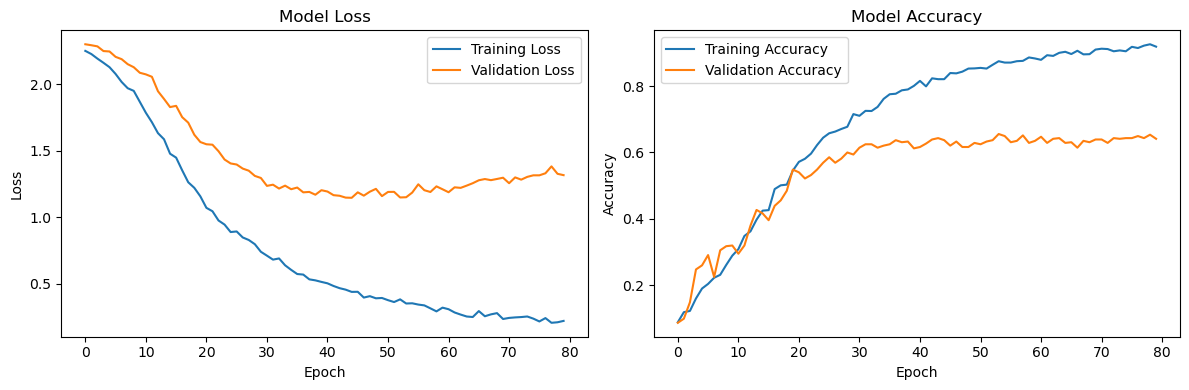

In [37]:
# Evaluate the model
test_loss_cnn_api_cw, test_accuracy_cnn_api_cw = model_cnn_api_cw.evaluate(x_test, y_test)
print(f"Test accuracy: {test_accuracy_cnn_api_cw:.4f}")


plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_cnn_api_cw.history['loss'], label='Training Loss')
plt.plot(history_cnn_api_cw.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_cnn_api_cw.history['accuracy'], label='Training Accuracy')
plt.plot(history_cnn_api_cw.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()


plt.tight_layout()
plt.show()

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


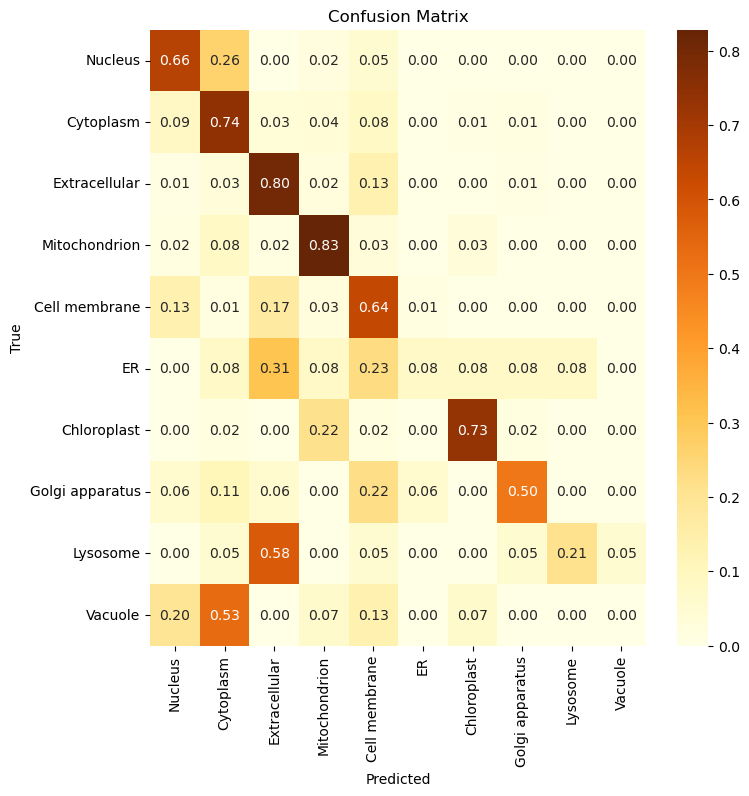

In [38]:
# Make predictions
y_pred = model_cnn_api_cw.predict(x_test)

# Convert one-hot encoded labels back to class indices
y_test_classes = np.argmax(y_test, axis=1)
y_pred_classes = np.argmax(y_pred, axis=1)

# Create confusion matrix
cm = confusion_matrix(y_test_classes, y_pred_classes, normalize='true')

# Plot confusion matrix
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='.2f', xticklabels=classes, yticklabels=classes, cmap='YlOrBr')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [39]:
# Save the model
model_cnn_api_cw.save('../res/model_cnn_api_cw.h5')

### ResNet

In [40]:
model_resnet_cw = resnet_model()
history_resnet_cw = model_resnet_cw.fit(
    x_train, y_train,
    batch_size = 128,
    epochs = 80,
    validation_split=0.2,
    class_weight=class_weights)

Epoch 1/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - accuracy: 0.1748 - loss: 2.4664 - val_accuracy: 0.2474 - val_loss: 2.2173
Epoch 2/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.4776 - loss: 1.3727 - val_accuracy: 0.2289 - val_loss: 2.1928
Epoch 3/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.6833 - loss: 0.8477 - val_accuracy: 0.1856 - val_loss: 2.1873
Epoch 4/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.7836 - loss: 0.5719 - val_accuracy: 0.1753 - val_loss: 2.1975
Epoch 5/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 0.8744 - loss: 0.4111 - val_accuracy: 0.1773 - val_loss: 2.2220
Epoch 6/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.9163 - loss: 0.3115 - val_accuracy: 0.1691 - val_loss: 2.3284
Epoch 7/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - accuracy: 0.9443 - loss: 0.2259 - val_accuracy: 0.1567 - val_loss: 2.3825
Epoch 8/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.9597 - loss: 0.1656 - val_accuracy: 0.1608 - v

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6909 - loss: 1.4217
Test accuracy: 0.7024


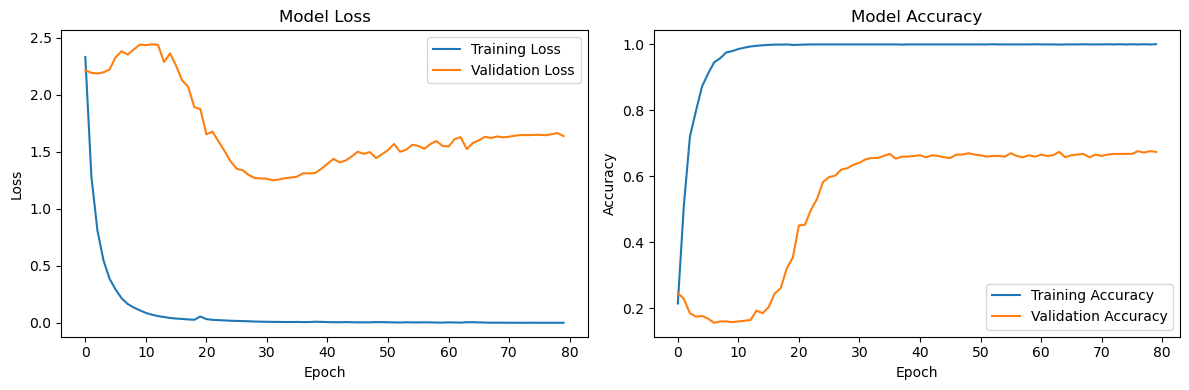

In [41]:
# Evaluate the model
test_loss_resnet_cw, test_accuracy_resnet_cw = model_resnet_cw.evaluate(x_test, y_test)
print(f"Test accuracy: {test_accuracy_resnet_cw:.4f}")


plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_resnet_cw.history['loss'], label='Training Loss')
plt.plot(history_resnet_cw.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_resnet_cw.history['accuracy'], label='Training Accuracy')
plt.plot(history_resnet_cw.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()


plt.tight_layout()
plt.show()

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


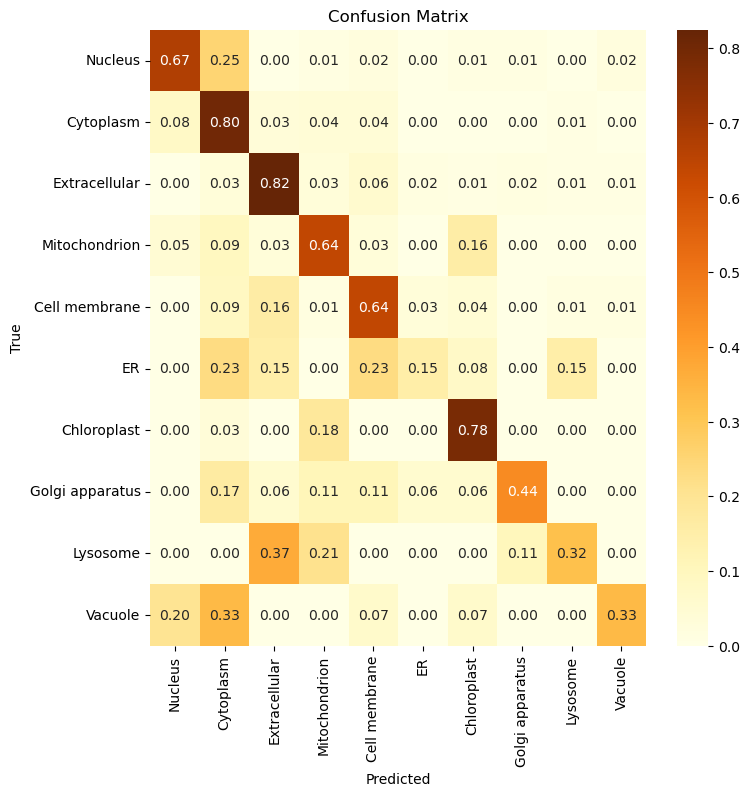

In [42]:
# Make predictions
y_pred = model_resnet_cw.predict(x_test)

# Convert one-hot encoded labels back to class indices
y_test_classes = np.argmax(y_test, axis=1)
y_pred_classes = np.argmax(y_pred, axis=1)

# Create confusion matrix
cm = confusion_matrix(y_test_classes, y_pred_classes, normalize='true')

# Plot confusion matrix
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='.2f', xticklabels=classes, yticklabels=classes, cmap='YlOrBr')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [43]:
# Save the model
model_resnet_cw.save('../res/model_resnet_cw.h5')

## Data augmentation

In [44]:
def selective_masking(x, mask_prob=0.1):
    mask = np.random.random(x.shape) < mask_prob
    x_masked = x.copy()
    x_masked[mask] = 0
    return x_masked

def pssm_smoothing(x, sigma=1.0):
    return gaussian_filter1d(x, sigma=sigma, axis=0)

def substring_sampling(x, min_length=0.8):
    seq_length = x.shape[0]
    start = np.random.randint(0, int(seq_length * (1 - min_length)))
    end = start + int(seq_length * min_length) + np.random.randint(0, int(seq_length * (1 - min_length)))
    return x[start:end]

def augment_pssm_data(x_train, y_train, target_samples=500):
    class_counts = {label: np.sum(y_train == label) for label in np.unique(y_train)}
    
    x_aug, y_aug = [], []
    
    for class_label, count in class_counts.items():
        class_indices = np.where(y_train == class_label)[0]
        x_class = x_train[class_indices]
        
        if count < target_samples:
            augment_factor = int(np.ceil((target_samples - count) / count))
            
            for i in range(len(x_class)):
                # Original sequence
                x_aug.append(x_class[i])
                y_aug.append(class_label)
                
                # Augmented sequences
                for _ in range(augment_factor):
                    aug_seq = x_class[i].copy()
                    
                    # Apply augmentation techniques
                    aug_type = np.random.choice(['mask', 'smooth', 'substring'])
                    if aug_type == 'mask':
                        aug_seq = selective_masking(aug_seq)
                    elif aug_type == 'smooth':
                        aug_seq = pssm_smoothing(aug_seq)
                    elif aug_type == 'substring':
                        aug_seq = substring_sampling(aug_seq)
                    
                    x_aug.append(aug_seq)
                    y_aug.append(class_label)
        else:
            # For classes that already have enough samples, just add the original data
            x_aug.extend(x_class)
            y_aug.extend([class_label] * len(x_class))
    
    return x_aug, np.array(y_aug)

# Import the data
x_train_aug = train['X_train']
y_train_aug = train['y_train']

# Augment the data
x_train_augmented, y_train_augmented = augment_pssm_data(x_train_aug, y_train_aug, target_samples=500)

# Pad sequences to the same length
max_length = max(seq.shape[0] for seq in x_train_augmented)
x_train_aug_padded = pad_sequences(x_train_augmented, maxlen=max_length, padding='post', dtype='float32')

# Shuffle the augmented dataset
indices = np.arange(len(x_train_aug_padded))
np.random.shuffle(indices)
x_train_aug = x_train_aug_padded[indices]
y_train_aug = y_train_augmented[indices]

# Class Distribution
unique, counts = np.unique(y_train_aug, return_counts=True)
print("\nClass distribution in y_train_aug:")
for u, c in zip(unique, counts):
    print(f"Class {u}: {c} samples")

# Convert labels to categorical
num_classes = len(np.unique(y_train_aug))
y_train_aug = to_categorical(y_train_aug, num_classes)


Class distribution in y_train_aug:
Class 0: 676 samples
Class 1: 567 samples
Class 2: 535 samples
Class 3: 699 samples
Class 4: 570 samples
Class 5: 504 samples
Class 6: 672 samples
Class 7: 531 samples
Class 8: 540 samples
Class 9: 531 samples


### DNN

In [45]:
# Create the model 
model_dnn_aug = dnn_model()

history_dnn_aug = model_dnn_aug.fit(x_train_aug, y_train_aug, 
                    epochs=80, 
                    batch_size=128, 
                    validation_split = 0.2)

Epoch 1/80
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.1465 - loss: 2.2589 - val_accuracy: 0.3279 - val_loss: 2.0841
Epoch 2/80
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2981 - loss: 2.0311 - val_accuracy: 0.4833 - val_loss: 1.8678
Epoch 3/80
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4419 - loss: 1.8008 - val_accuracy: 0.6515 - val_loss: 1.6171
Epoch 4/80
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5797 - loss: 1.5230 - val_accuracy: 0.7124 - val_loss: 1.4180
Epoch 5/80
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6443 - loss: 1.3225 - val_accuracy: 0.7399 - val_loss: 1.2584
Epoch 6/80
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6924 - loss: 1.1699 - val_accuracy: 0.7605 - val_loss: 1.1427
Epoch 7/80
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7283 - loss: 1.0660 - val_accuracy: 0.7691 - val_loss: 1.0575
Epoch 8/80
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7567 - loss: 0.9592 - val_accuracy: 0.7803 - val_los

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7287 - loss: 1.1119 
Test accuracy: 0.7496


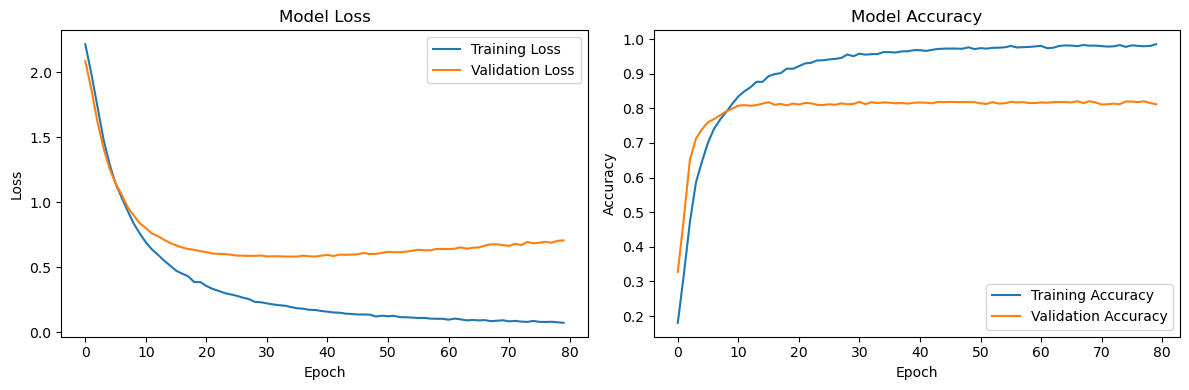

In [46]:
# Evaluate the model
test_loss_dnn_aug, test_accuracy_dnn_aug = model_dnn_aug.evaluate(x_test, y_test)
print(f"Test accuracy: {test_accuracy_dnn_aug:.4f}")


plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_dnn_aug.history['loss'], label='Training Loss')
plt.plot(history_dnn_aug.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_dnn_aug.history['accuracy'], label='Training Accuracy')
plt.plot(history_dnn_aug.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()


plt.tight_layout()
plt.show()

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


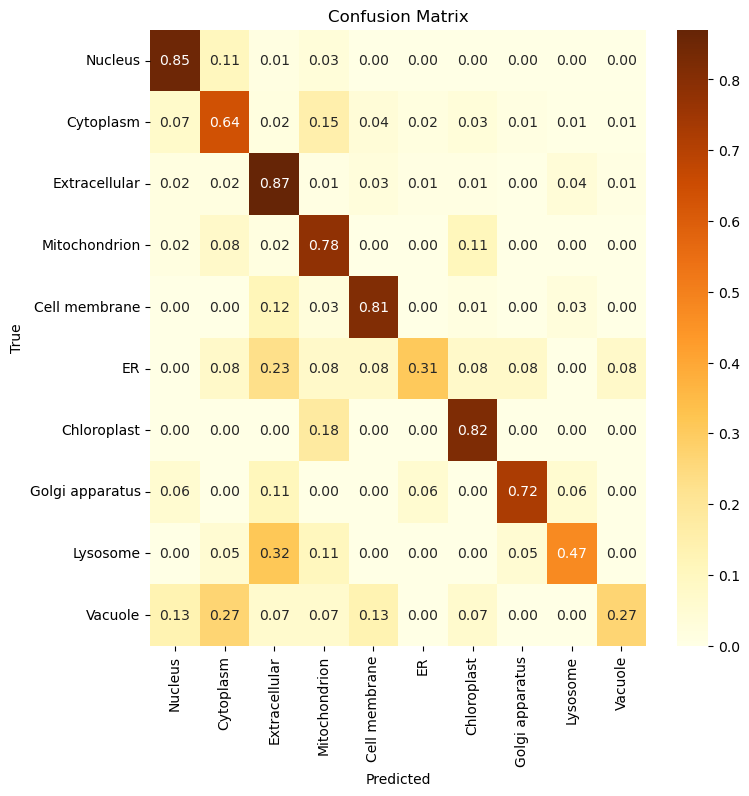

In [47]:
# Make predictions
y_pred = model_dnn_aug.predict(x_test)

# Convert one-hot encoded labels back to class indices
y_test_classes = np.argmax(y_test, axis=1)
y_pred_classes = np.argmax(y_pred, axis=1)

# Create confusion matrix
cm = confusion_matrix(y_test_classes, y_pred_classes, normalize='true')

# Plot confusion matrix
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='.2f', xticklabels=classes, yticklabels=classes, cmap='YlOrBr')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [48]:
# Save the model
model_dnn_aug.save('../res/model_dnn_aug.h5')

### CNN

In [49]:
model_cnn_aug = cnn_model()

history_cnn_aug = model_cnn_aug.fit(
    x_train_aug, y_train_aug,
    batch_size = 128,
    epochs = 80,
    validation_split=0.2)

Epoch 1/80
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - accuracy: 0.1575 - loss: 2.7414 - val_accuracy: 0.0747 - val_loss: 2.3302
Epoch 2/80
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - accuracy: 0.3695 - loss: 1.9667 - val_accuracy: 0.0747 - val_loss: 2.5357
Epoch 3/80
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - accuracy: 0.4734 - loss: 1.5868 - val_accuracy: 0.0747 - val_loss: 2.8243
Epoch 4/80
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - accuracy: 0.5668 - loss: 1.3012 - val_accuracy: 0.0747 - val_loss: 3.0745
Epoch 5/80
37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - accuracy: 0.6325 - loss: 1.1074 - val_accuracy: 0.0790 - val_loss: 3.4214
Epoch 6/80
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 103ms/step - accuracy: 0.6596 - loss: 1.0157 - val_accuracy: 0.1142 - val_loss: 3.4973
Epoch 7/80
37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - accuracy: 0.6996 - loss: 0.8748 - val_accuracy: 0.1288 - val_loss: 3.6435
Epoch 8/80
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - accuracy: 0.7317 - loss: 0.7938 - val_accuracy: 0.1588 - 

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7886 - loss: 0.8483
Test accuracy: 0.8252


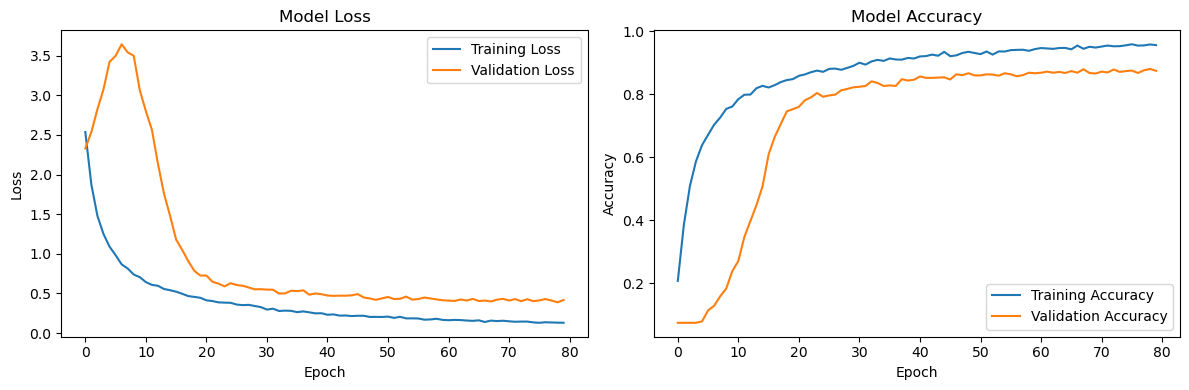

In [50]:
# Evaluate the model
test_loss_cnn_aug, test_accuracy_cnn_aug = model_cnn_aug.evaluate(x_test, y_test)
print(f"Test accuracy: {test_accuracy_cnn_aug:.4f}")


plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_cnn_aug.history['loss'], label='Training Loss')
plt.plot(history_cnn_aug.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_cnn_aug.history['accuracy'], label='Training Accuracy')
plt.plot(history_cnn_aug.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()


plt.tight_layout()
plt.show()

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


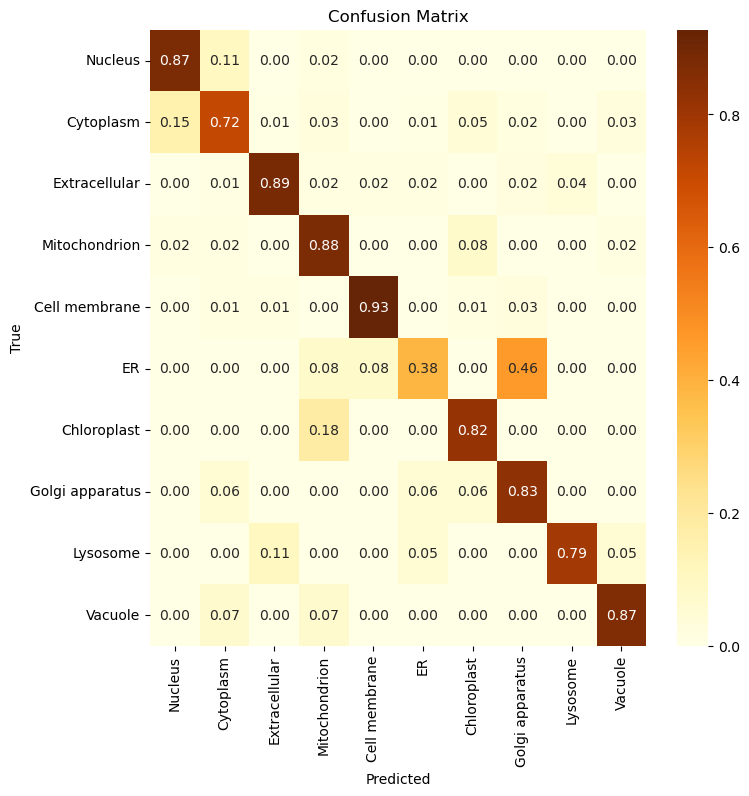

In [51]:
# Make predictions
y_pred = model_cnn_aug.predict(x_test)

# Convert one-hot encoded labels back to class indices
y_test_classes = np.argmax(y_test, axis=1)
y_pred_classes = np.argmax(y_pred, axis=1)

# Create confusion matrix
cm = confusion_matrix(y_test_classes, y_pred_classes, normalize='true')

# Plot confusion matrix
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='.2f', xticklabels=classes, yticklabels=classes, cmap='YlOrBr')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [52]:
# Save the model
model_cnn_aug.save('../res/model_cnn_aug.h5')

### CNN - functional API

In [53]:
model_cnn_api_aug = cnn_api_model()
history_cnn_api_aug = model_cnn_api_aug.fit(
    x_train_aug, y_train_aug,
    batch_size = 128,
    epochs = 80,
    validation_split=0.2)

Epoch 1/80
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.1212 - loss: 2.2945 - val_accuracy: 0.1700 - val_loss: 2.2470
Epoch 2/80
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.1762 - loss: 2.2341 - val_accuracy: 0.2541 - val_loss: 2.1588
Epoch 3/80
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.2259 - loss: 2.1458 - val_accuracy: 0.3648 - val_loss: 2.0448
Epoch 4/80
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.3115 - loss: 2.0133 - val_accuracy: 0.4129 - val_loss: 1.8833
Epoch 5/80
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.3610 - loss: 1.8469 - val_accuracy: 0.5124 - val_loss: 1.7089
Epoch 6/80
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.4414 - loss: 1.6962 - val_accuracy: 0.6017 - val_loss: 1.5408
Epoch 7/80
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.5108 - loss: 1.5114 - val_accuracy: 0.6034 - val_loss: 1.4063
Epoch 8/80
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.5448 - loss: 1.3851 - val_accuracy: 0.6575 - v

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6706 - loss: 1.6011
Test accuracy: 0.6976


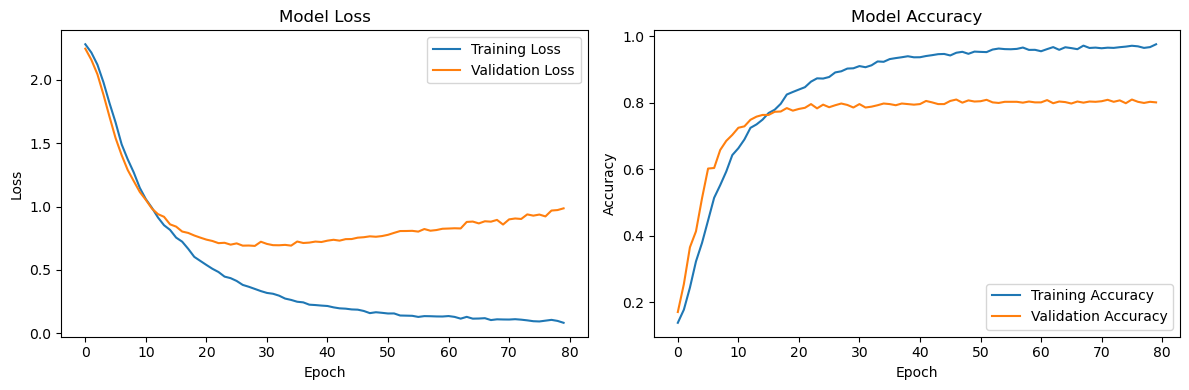

In [54]:
# Evaluate the model
test_loss_cnn_api_aug, test_accuracy_cnn_api_aug = model_cnn_api_aug.evaluate(x_test, y_test)
print(f"Test accuracy: {test_accuracy_cnn_api_aug:.4f}")


plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_cnn_api_aug.history['loss'], label='Training Loss')
plt.plot(history_cnn_api_aug.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_cnn_api_aug.history['accuracy'], label='Training Accuracy')
plt.plot(history_cnn_api_aug.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()


plt.tight_layout()
plt.show()

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


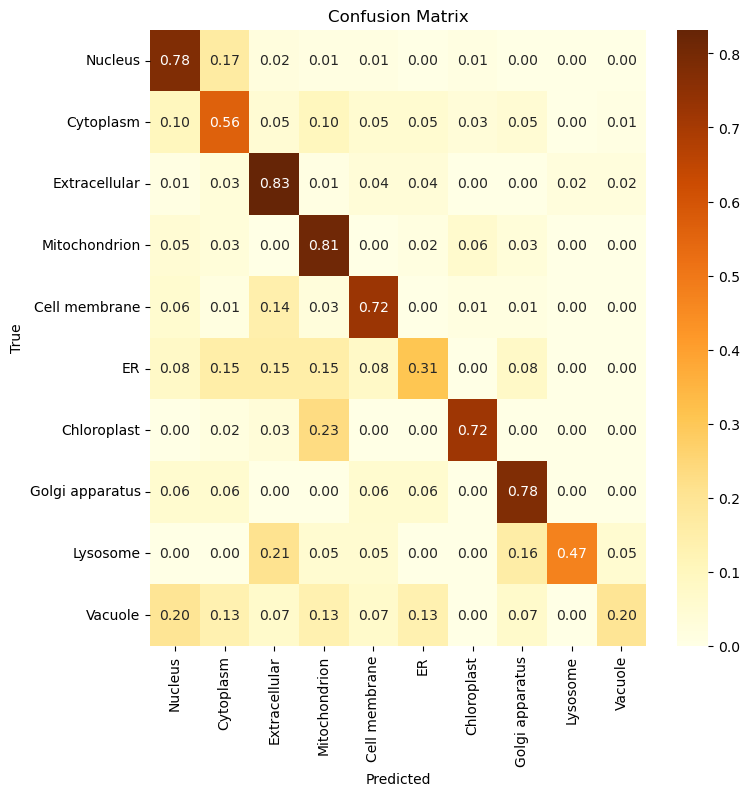

In [55]:
# Make predictions
y_pred = model_cnn_api_aug.predict(x_test)

# Convert one-hot encoded labels back to class indices
y_test_classes = np.argmax(y_test, axis=1)
y_pred_classes = np.argmax(y_pred, axis=1)

# Create confusion matrix
cm = confusion_matrix(y_test_classes, y_pred_classes, normalize='true')

# Plot confusion matrix
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='.2f', xticklabels=classes, yticklabels=classes, cmap='YlOrBr')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [56]:
# Save the model
model_cnn_api_aug.save('../res/model_cnn_api_aug.h5')

### ResNet

In [57]:
model_resnet_aug = resnet_model()
history_resnet_aug = model_resnet_aug.fit(
    x_train_aug, y_train_aug,
    batch_size = 128,
    epochs = 80,
    validation_split=0.2)

Epoch 1/80
37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.2449 - loss: 2.3281 - val_accuracy: 0.1528 - val_loss: 2.2182
Epoch 2/80
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - accuracy: 0.6821 - loss: 1.0632 - val_accuracy: 0.1871 - val_loss: 2.1436
Epoch 3/80
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - accuracy: 0.8180 - loss: 0.6774 - val_accuracy: 0.2558 - val_loss: 2.0764
Epoch 4/80
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - accuracy: 0.8852 - loss: 0.4426 - val_accuracy: 0.2232 - val_loss: 2.1133
Epoch 5/80
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.9317 - loss: 0.3041 - val_accuracy: 0.2936 - val_loss: 2.0097
Epoch 6/80
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - accuracy: 0.9569 - loss: 0.2304 - val_accuracy: 0.3485 - val_loss: 1.8913
Epoch 7/80
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - accuracy: 0.9730 - loss: 0.1724 - val_accuracy: 0.4163 - val_loss: 1.6993
Epoch 8/80
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - accuracy: 0.9842 - loss: 0.1296 - val_accuracy: 0.5227 - v

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6536 - loss: 1.9432
Test accuracy: 0.6945


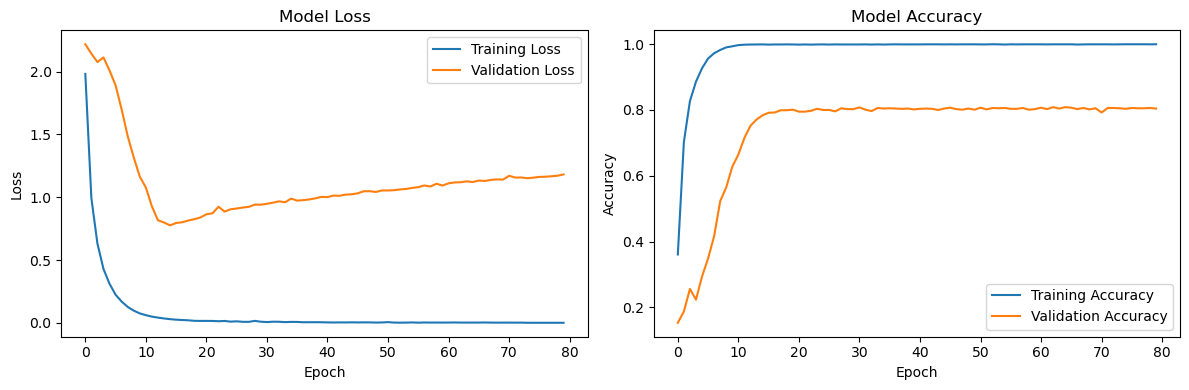

In [58]:
# Evaluate the model
test_loss_resnet_aug, test_accuracy_resnet_aug = model_resnet_aug.evaluate(x_test, y_test)
print(f"Test accuracy: {test_accuracy_resnet_aug:.4f}")


plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history_resnet_aug.history['loss'], label='Training Loss')
plt.plot(history_resnet_aug.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_resnet_aug.history['accuracy'], label='Training Accuracy')
plt.plot(history_resnet_aug.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()


plt.tight_layout()
plt.show()

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


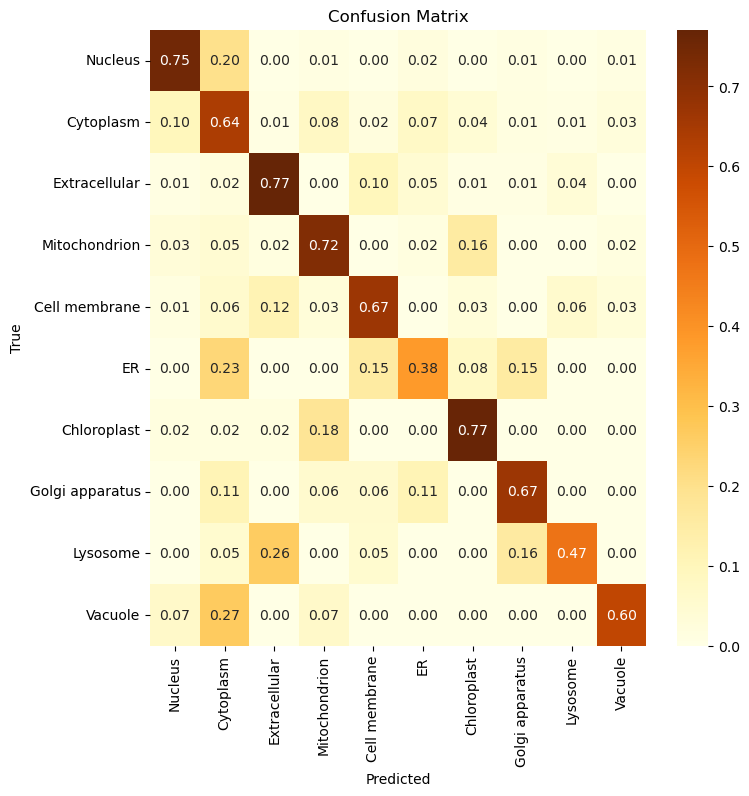

In [59]:
# Make predictions
y_pred = model_resnet_aug.predict(x_test)

# Convert one-hot encoded labels back to class indices
y_test_classes = np.argmax(y_test, axis=1)
y_pred_classes = np.argmax(y_pred, axis=1)

# Create confusion matrix
cm = confusion_matrix(y_test_classes, y_pred_classes, normalize='true')

# Plot confusion matrix
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='.2f', xticklabels=classes, yticklabels=classes, cmap='YlOrBr')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [60]:
# Save the model
model_resnet_aug.save('../res/model_resnet_aug.h5')

# Comparison

Table of Accuracy Values:


Method,Base,CW,Aug
Model,,,
CNN,0.8094,0.8220,0.8252
CNN_API,0.6929,0.6850,0.6976
DNN,0.7024,0.7512,0.7496
ResNet,0.7512,0.7024,0.6945


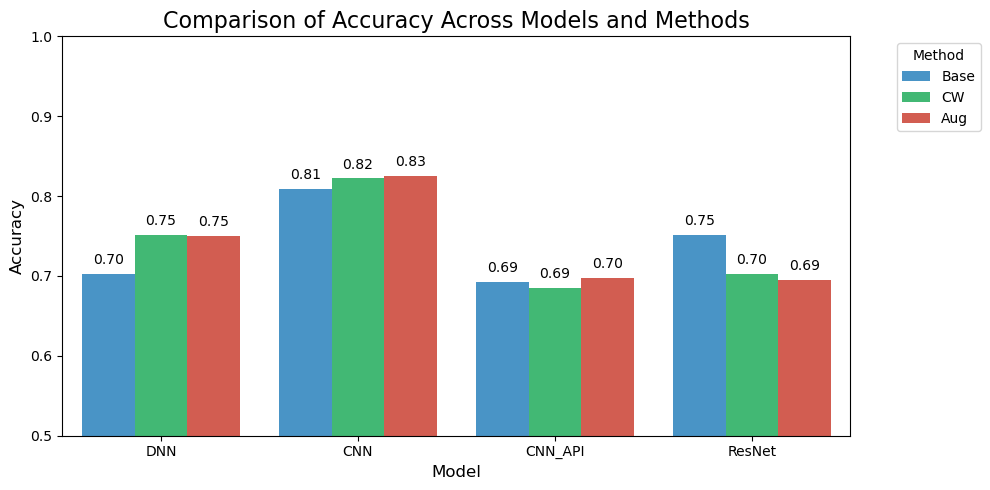

In [61]:
data = {
    'Model': ['DNN', 'DNN', 'DNN', 'CNN', 'CNN', 'CNN', 'CNN_API', 'CNN_API', 'CNN_API', 'ResNet', 'ResNet', 'ResNet'],
    'Method': ['Base', 'CW', 'Aug', 'Base', 'CW', 'Aug', 'Base', 'CW', 'Aug', 'Base', 'CW', 'Aug'],
    'Accuracy': [test_accuracy_dnn, test_accuracy_dnn_cw, test_accuracy_dnn_aug,
                 test_accuracy_cnn, test_accuracy_cnn_cw, test_accuracy_cnn_aug,
                 test_accuracy_cnn_api, test_accuracy_cnn_api_cw, test_accuracy_cnn_api_aug,
                 test_accuracy_resnet, test_accuracy_resnet_cw, test_accuracy_resnet_aug]
}

# Create a DataFrame
df = pd.DataFrame(data)

# Pivot the table to get the desired format
pivot_df = df.pivot(index='Model', columns='Method', values='Accuracy')

# Reorder the columns
pivot_df = pivot_df[['Base', 'CW', 'Aug']]

# Display the table
print("Table of Accuracy Values:")
display(pivot_df.style.format("{:.4f}").highlight_max(axis=1))

# Function to add value labels on bars
def add_value_labels(ax, spacing=5):
    for rect in ax.patches:
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2

        label = f"{y_value:.2f}"
        
        ax.annotate(label, (x_value, y_value), xytext=(0, spacing),
                    textcoords="offset points", ha='center', va='bottom')

colors = ['#3498db', '#2ecc71', '#e74c3c']

plt.figure(figsize=(10, 5))
ax = sns.barplot(x='Model', y='Accuracy', hue='Method', data=df, palette=colors)
plt.title('Comparison of Accuracy Across Models and Methods', fontsize=16)
plt.xlabel('Model', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.ylim(0.5, 1.0)  # Adjust this range based on your actual accuracy values
add_value_labels(ax)
plt.legend(title='Method', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## Cross-validation of the most performant model

In [71]:
training = KerasClassifier(build_fn=model_cnn_aug,
                           epochs=80, batch_size=128, verbose=0)

kfold = KFold(n_splits=5, shuffle=True)

cv_results = cross_val_score(training, x_train_aug, 
                             y_train_aug, cv=kfold)

/opt/miniconda3/envs/aiao-env/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 12 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/opt/miniconda3/envs/aiao-env/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/opt/miniconda3/envs/aiao-env/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 12 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/opt/miniconda3/envs/aiao-env/lib/python3.12/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future r

Results Cross validation : 90.94% (1.07%)


In [72]:
print("Cross validation accuracies:", cv_results)
print("Results Cross validation : %.2f%% (%.2f%%)"%(cv_results.mean()*100, cv_results.std()*100))

Cross validation accuracies: [0.89871245 0.89527897 0.92360515 0.91502146 0.91416309]
Results Cross validation : 90.94% (1.07%)
